In [1]:
import numpy as np 
import torch 
import ase
from ase.visualize import view
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# if you don't have some of these packages, uncomment the following line and run the cell

# ! pip install ase torch numpy matplotlib 

Atomistic simulations form one of the cornerstones of research in condensed matter physics, chemistry, and materials science. All properties of a given atomic configuration $A$, or equivalently a collection of its $N$ nuclear positions and charges, are encoded within the electronic Hamiltonian ($\hat{H}$) which is a quantum mechanical (QM) operator. Electronic energies $\varepsilon$, along with the wavefunctions $\psi$ from which other properties may be derived, are obtained as solutions of the Time-Independent Schrödinger's equation (TISE), 
$$ \hat{H} |\psi \rangle = \varepsilon |\psi \rangle, $$
where $\hat{H}$ is the Hamiltonian operator decribing the physics of the interaction, $|\psi \rangle$ is the energy eigenstate and $\varepsilon$, is the corresponding eigenvalue. 

Beyond the TISE, a lot of problems in physics can be formulated as eigenvalue problems, such as determining the modes of vibration in materials, spin interactions (via Heisenberg or Hubbard Hamiltonians), or photonic band structures. 

Even though the TISE takes a deceptively simple form, it is very hard to solve it analytically or even approximately for many-body systems. As a result, a large portion of computational quantum physics is dedicated to finding approximate methods for solving or simplifying the eigenvalue problem. A lot of ML effort has been spent in bypassing this process. Instead of solving the Schrödinger equation from first principles, one can train ML models to directly learn structure–property relationships, for example learning to predict energies or band gaps (difference of eigenvalues) directly from input structures. 

Below, we will encounter some examples of such surrogate models starting from simple two-level Hamiltonians, which allow us to visually and analytically understand the impact of symmetries and distortions. We will observe the effect of structural distortions on eigenvalues (e.g., gap opening via eigenvalue repulsion), construct synthetic atomic configurations and band gaps and contrast two modeling approached. We will learn the bandgap directly from atomic structure, and compare it to learning the underlying Hamiltonian matrix and using its eigenspectrum to recover target property.

Can you think of benefits/limitations of one approach versus the other?

![Alt text](figs/schematic.png)

Following this we'll go to a physically motivated $H_2$ molecule and study symmetry-breaking distortions in benzene

Along the way, we will compare
- Direct ML models for predicting bandgaps or energy levels
- ML models that learn the Hamiltonian matrix, which can then be used to compute *many* properties

## Two-Level System 

Rather than working with abstract operators directly, we represent $\hat{H}$ as a matrix on a _basis_. Let $\left\{\left|\phi_i\right\rangle\right\}$ be a set of linearly independent states (or orbitals), then the matrix elements of $\hat{H}$ can be obtained as 
$$
\mathbf{H}_{i j}=\left\langle\phi_i\right| \hat{H}\left|\phi_j\right\rangle
$$
Note that the matrix corresponding to the Hamiltonian is Hermitian (i.e. $\mathbf{H} = \mathbf{H}^\dagger $). 

A 2×2 Hermitian Hamiltonian can represent many physical systems such as coupled quantum dots, spin 1/2 particles in magnetic fields, or electronic interactions in molecules. Consider the Hamiltonian of a two-level quantum system with some coupling $V$.

$$ 
\mathbf{H}(\Delta_1, \Delta_2,  V) = \begin{pmatrix}
\Delta_1 & V \\
V & \Delta_2
\end{pmatrix}
$$

In writing this matrix, we chose a basis of two orthonormal states $|1\rangle$ and $|2\rangle$, in which, the diagonal elements $\Delta_1$ and $\Delta_2$ represent the on-site energies or _uncoupled_ energy levels, and the off-diagonal element $V$ represents the coupling or tunneling amplitude between the two states.

Thus, the matrix

$$
\mathbf{H}=\underbrace{\left(\begin{array}{cc}
\Delta_1 & 0 \\
0 & \Delta_2
\end{array}\right)}_{\text {Unperturbed }}+\underbrace{\left(\begin{array}{cc}
0 & V \\
V & 0
\end{array}\right)}_{\text {Coupling interaction }}
$$



The eigenvalues of $\mathbf{H}$ are obtained as, 

$$
\varepsilon =  \frac{(\Delta_1+\Delta_2)\pm \sqrt{(\Delta_1+\Delta_2)^2 - 4 (\Delta_1 \Delta_2) V^2}}{2}
$$

When $V \neq 0$, the energy levels repel and do not cross — this is _level repulsion_ or the formation of a _band gap_.  What is the minimum energy gap we can obtain in such a system? As $\Delta$ is varied, the minimum energy gap is \(2V\).


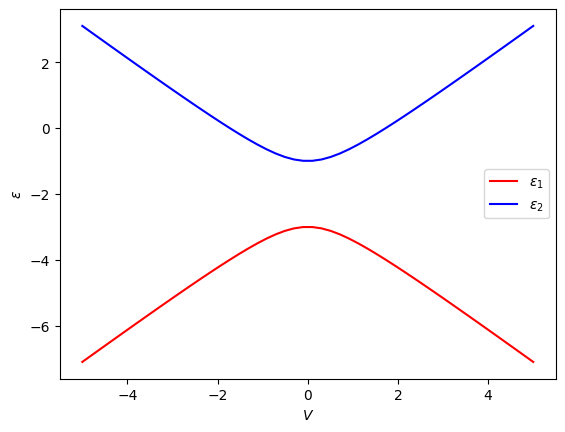

In [2]:
M = torch.zeros(2,2, dtype = torch.float64)
delta1 = -3
delta2 = -1
M[0,0] = delta1
M[1,1] = delta2
couplings = np.linspace(-5,5)
evals = []
for eps in couplings:
    M[0,1] = M[1,0] = eps
    e = torch.linalg.eigvalsh(M)
    evals.extend(e)
plt.plot(couplings, evals[::2], 'r', label = r'$\varepsilon_1$')
plt.plot(couplings, evals[1::2], 'b', label = r'$\varepsilon_2$')
plt.xlabel(r'$V$')
plt.ylabel(r'$\varepsilon$')
plt.legend()

# plt.axhline(y = energy1, c='k', ls = '--')
# plt.axhline(y = energy2, c='k', ls = '--')


### Eigenvalue Crossing

Now consider the case where the off-diagonal coupling vanishes:

$$
H(\Delta, \eta, V=0) = \begin{pmatrix}
\Delta & 0 \\
0 & -\Delta + \eta
\end{pmatrix}
$$
If $\eta = 0$, the eigenvalues are simply $\varepsilon = \pm \Delta$. Hence, the two energy levels cross exactly at $\Delta = 0$. This happens when two quantum states are completely uncoupled or _symmetry-forbidden_ to mix.


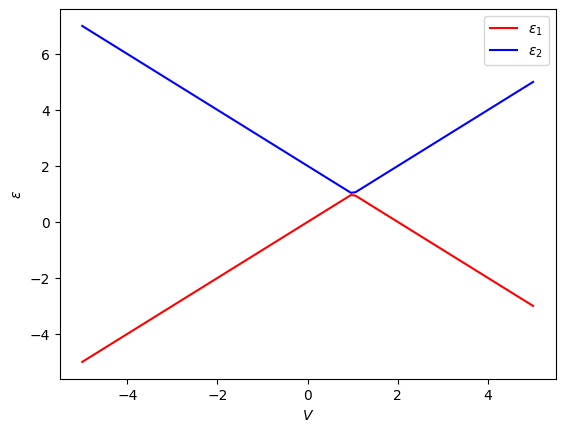

In [3]:
M = torch.zeros(2,2, dtype = torch.float64)
couplings = np.linspace(-5,5, 100)
OFFSET = 2
evals = []
for eps in couplings:
    M[0,0] = eps
    M[1,1] = -1*eps +OFFSET
    e = torch.linalg.eigvalsh(M)
    evals.extend(e)
plt.plot(couplings, evals[::2], 'r', label = r'$\varepsilon_1$')
plt.plot(couplings, evals[1::2], 'b', label = r'$\varepsilon_2$')
plt.xlabel(r'$V$')
plt.ylabel(r'$\varepsilon$')
plt.legend()

What happens if $\eta$ is non-zero? Can you explain this behavior?

# H chains

We generate a set of 2×2 Hermitian (symmetric) matrices, corresponding to the displacement of 2 Hydrogen atoms. 

In [2]:
from ase import Atoms
def make_diatomic(distance: float):
    return Atoms('H2', positions=[[0, 0, 0], [distance, 0, 0]]) # notice, we're displacing the atoms along the x-coordinate.

distances = np.linspace(0.5, 3.0, 100)
frames = [make_diatomic(d) for d in distances]

# you can visualize the structure we computed above by uncommenting the next line
# view(frames) # this launches an interactive ASE visualization window

def hopping(distance, alpha=1.5):
    return -np.exp(-alpha * distance)

def make_hamiltonian(alpha = 1.5, delta1=0.0, delta2=1.0, distance=0.0):
    t = hopping(distance, alpha = alpha)
    # mimics an effective orbital energy shift due to varying electronic environments
    return np.array([[delta1+ 0.2 * np.sin(4 * np.pi * distance), t],
                     [t, delta2+ 0.1 * np.cos(2 * np.pi * distance)]])

DELTA1 = -0.5
DELTA2 = -0.125
DTYPE=torch.float64
hamiltonians = np.array([make_hamiltonian(delta1 = DELTA1, delta2 = DELTA2, distance = d) for d in distances])
eigvals = np.linalg.eigvalsh(hamiltonians)
gaps = eigvals[:, 1] - eigvals[:, 0]


X = torch.tensor(distances[:, None], dtype=DTYPE)  # inputs to the model 
Y_gap = torch.tensor(gaps, dtype=DTYPE)  
Y_H = torch.tensor(hamiltonians, dtype=DTYPE)  

Text(0, 0.5, '$\\Delta \\epsilon$')

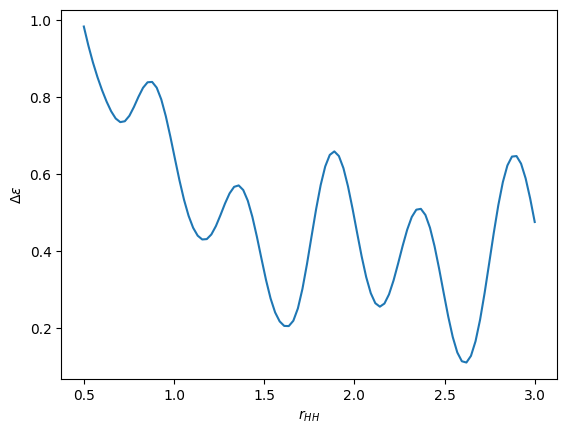

In [3]:
plt.plot(distances, gaps)
plt.xlabel(r'$r_{HH}$')
plt.ylabel(r'$\Delta \epsilon$')
# plt.plot(eigvals[:,0], 'r')
# plt.plot(eigvals[:,1], 'b')

### Learning the Eigenvalue Gap Directly

We train a simple MLP to predict the energy gap $\Delta \varepsilon = \varepsilon _2 - \varepsilon _1 $ from the displacement between two H atoms.


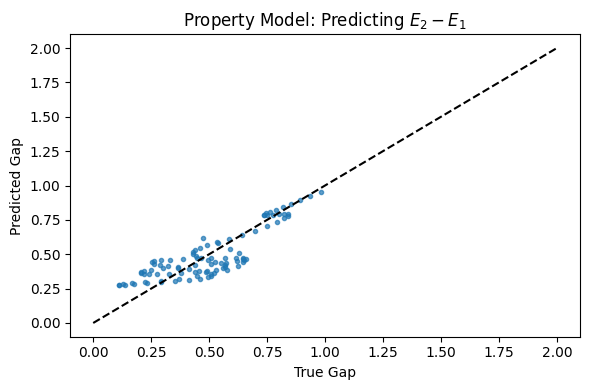

In [4]:
dataset = TensorDataset(X, Y_gap)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

class GapPredictor(nn.Module):
    def __init__(self, nhidden=16,activation = 'SiLU'):
        super().__init__()
        if isinstance(activation, str):
            try:
                activation= getattr(nn, activation)()
            except:
                raise ValueError("Invalid activation function name.")
        else:
            assert callable(activation)
            
        self.model = nn.Sequential(
            nn.Linear(1, nhidden),
            activation,
            nn.Linear(nhidden, nhidden),
            activation,
            nn.Linear(nhidden, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze()

NHIDDEN = 200
ACTIVATION = 'SiLU'
gap_model = GapPredictor(nhidden = NHIDDEN, activation=ACTIVATION)
gap_model = gap_model.double()
optimizer = torch.optim.Adam(gap_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

NEPOCHS = 1000
for epoch in range(NEPOCHS):
    for xb, yb in loader:
        pred = gap_model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()




gap_model.eval()
with torch.no_grad():
    preds = gap_model(X)

plt.figure(figsize=(6,4))
plt.plot(gaps, preds, '.', alpha=0.7)
plt.xlabel("True Gap")
plt.ylabel("Predicted Gap")
plt.title("Property Model: Predicting $E_2 - E_1$")
# plt.grid(True)
plt.plot([0,2], [0,2], 'k--')
plt.tight_layout()
plt.show()



### Learning the intermediate matrix 

Now let's try to model the intermediate Hamiltonian instead. 
How many independent entries are there in a symmetric 2x2 matrix? 

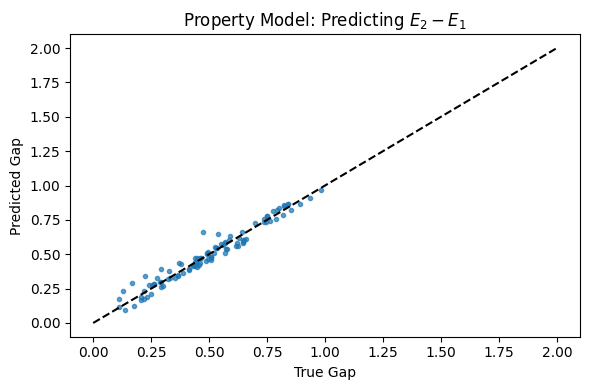

In [5]:
class HamiltonianPredictor(nn.Module):
    def __init__(self, nhidden=16, activation = 'SiLU', dtype = torch.float64):
        super().__init__()
        if isinstance(activation, str):
            try:
                activation= getattr(nn, activation)()
            except:
                raise ValueError("Invalid activation function name.")
        else:
            assert callable(activation)
            
        self.model = nn.Sequential(
            nn.Linear(1, nhidden),
            activation,
            nn.Linear(nhidden, nhidden),
            activation,
            nn.Linear(nhidden, 3)
        )
        self.dtype = dtype
    
    def forward(self, x):
        out = self.model(x)
        Hs = torch.zeros(x.shape[0], 2,2, dtype=self.dtype)
        Hs[:,0,0] = out[:, 0]
        Hs[:,1,1] = out[:, 2]
        Hs[:,0,1] = out[:, 1]
        Hs[:,1,0] = out[:, 1]
    
        return Hs

NHIDDEN = 200
ACTIVATION = 'SiLU'
ham_model = HamiltonianPredictor(nhidden = NHIDDEN, activation=ACTIVATION)
ham_model = ham_model.double()
optimizer = torch.optim.Adam(ham_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

dataset = TensorDataset(X, Y_H)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

NEPOCHS = 2000
for epoch in range(NEPOCHS):
    for xb, yb in loader:
        pred = ham_model(xb)
        pred_eigvals = torch.linalg.eigvalsh(pred)
        true_eigvals = torch.linalg.eigvalsh(yb)
        loss = loss_fn(true_eigvals, pred_eigvals)
        # loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

ham_model.eval()
with torch.no_grad():
    predHs = ham_model(X)
    
pred_eigvals = np.linalg.eigvalsh(predHs)
pred_gaps = pred_eigvals[:, 1] - pred_eigvals[:, 0]

plt.figure(figsize=(6,4))
plt.plot(gaps, pred_gaps, '.', alpha=0.7)
plt.xlabel("True Gap")
plt.ylabel("Predicted Gap")
plt.title("Property Model: Predicting $E_2 - E_1$")
# plt.grid(True)
plt.plot([0,2], [0,2], 'k--')
plt.tight_layout()
plt.show()

Try to modify $\Delta_1$, $\Delta_2$ and $V$ to create change the bandgap function and repeat the learning exercise above. What if the bandgap had spiky behavior?

What if in the examples above, we chose a basis in which each H atom was represented not by one state, but instead by two states? F
What if, instead of representing each hydrogen atom with one state (or orbital), we included two orbitals per atom? Then our basis would not just be

$$
\left|\phi_1\right\rangle = \text { orbital on H1, } \quad\left|\phi_2\right\rangle= \text { orbital on H2 }
$$

but instead

$$
\{\left|\phi_1\right\rangle, \left|\phi_2\right\rangle\} \text{ on H1}, \quad\{\left|\phi_3\right\rangle, \left|\phi_4\right\rangle\} \text{ on H2}
$$

Now we have 4 basis states, so the Hamiltonian becomes a $4 \times 4$ matrix.
The diagonal terms of the matrix convey the energy of each orbital, whearas the off-diagonal terms indicate how much each orbitals interact with the other. 

Remember, each orbital can accommodate two electrons and the band-gap, is defined as the difference of the highest occupied orbital and the lowest unoccupied orbital. For the case of $H_2$, this would mean the difference of the first and second energy level. How would you model the band gap in this case? Modify the example above to predict both the bandgap directly and the intermediate matrix
                                                                                                                                                        

What if the model was not aware of the Hermitian constraint of the Hamiltonian? Modify the code and discuss your observations

## Symmetry check

In the example above, we created a dataset of a Hydrogen molecule where the two H atoms were separated on the $x$-axis. Let's suppose the model learnt the bandgaps perfectly as a function of displacements. What do you think will happen if we now test this model on a structure where the H atoms are aligned along the $y$-axis? Since the displacement is still the same, just oriented differently, the bandgap should be unchanged theoretically. This is called _invariance_ of the target property under rotation. Do you expect the model to output a perfect prediction in this case? Why? Try it out!

In [9]:
distance = 0.3
H2_displaced_y = ase.Atoms('H2', positions=[[0, 0, 0], [0,distance, 0]])

hamiltonians = np.array([make_hamiltonian(delta1 = DELTA1, delta2 = DELTA2, distance = distance)])
eigvals = np.linalg.eigvalsh(hamiltonians)
gaps = eigvals[:, 1] - eigvals[:, 0]


X = torch.tensor(np.asarray([distance])[:, None], dtype=DTYPE)  # inputs to the model 
Y_gap = torch.tensor(gaps, dtype=DTYPE)  
Y_H = torch.tensor(hamiltonians, dtype=DTYPE)  

In [12]:
with torch.no_grad():
    predHs = ham_model(X)
    
pred_eigvals = np.linalg.eigvalsh(predHs)
pred_gaps = pred_eigvals[:, 1] - pred_eigvals[:, 0]

Yes, we did expect the model output to be invariant under rotations because we are using the distance between the two atoms as model input, which reflects the invariance of the property we're trying to model!

# Benzene 
Let us crank up the complexity slightly and look at benzene molecule, which is a very symmetric molecule. Do you know what symmetry group it corresponds to?

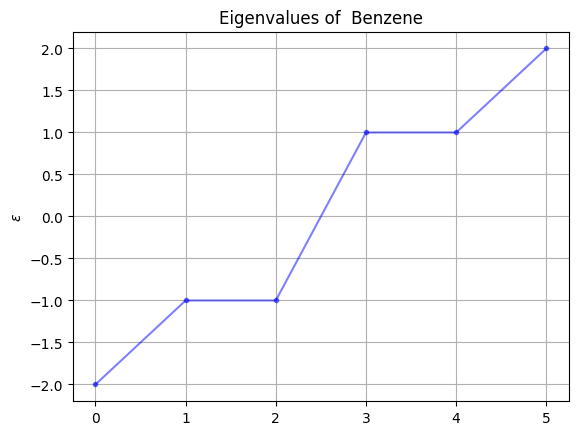

In [19]:
def benzene_coords(R=1.0):
    angles = np.linspace(0, 2*np.pi, 7)[:-1]
    return np.stack([R * np.cos(angles), R * np.sin(angles)], axis=-1)

def apply_distortion(coords, mode='E2g', epsilon=0.1):
    if mode == 'E2g':
        # One real E2g component 
        displacement_vectors = np.array([
            [ 1,  0],
            [ 0.5, -np.sqrt(3)/2],
            [-0.5, -np.sqrt(3)/2],
            [-1,  0],
            [-0.5,  np.sqrt(3)/2],
            [ 0.5,  np.sqrt(3)/2]
        ])
        return coords + epsilon * displacement_vectors

    elif mode == 'A1g':
        # Radial symmetric breathing mode (all atoms push out/in equally)
        displaced = []
        for i in range(len(coords)):
            r_hat = coords[i] / np.linalg.norm(coords[i])
            displaced.append(coords[i] + epsilon * r_hat)
        return np.array(displaced)

    else:
        raise ValueError(f"Unknown mode: {mode}. Choose 'E2g' or 'A1g'.")


def compute_hamiltonian(coords, t0=1.0, alpha=5.0, d0=None):
    N = len(coords)
    if d0 is None:
        d0 = np.linalg.norm(coords[0] - coords[1])
    H = np.zeros((N, N))
    for i in range(N):
        j = (i + 1) % N
        d = np.linalg.norm(coords[i] - coords[j])
        t = t0 * np.exp(-alpha * (d - d0))
        H[i, j] = H[j, i] = -t
    return H



benzene = benzene_coords()
# plt.plot(benzene_coords()[:,0], benzene_coords()[:,1], 'bo') # visualize the benzene molecule

d0 = np.linalg.norm(benzene[0] - benzene[1])  
H = compute_hamiltonian(benzene,t0=1.0, alpha=3.0, d0=d0)
eigvals = np.linalg.eigvalsh(H)

plt.plot(eigvals, 'b.-', alpha = 0.5, label = 'pure')
plt.title("Eigenvalues of  Benzene")
plt.ylabel(r"$\varepsilon$")
plt.grid(True)
plt.show()

Notice that the eigenvalues appear in certain degeneracies, owing to the symmetric nature of the structure. Depending on how we distort the structure of the molecule, we can either preserve the degeneracy or break it entirely! Below, we consider two different modes of distortions

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/var/folders/k9/q06q1_g56p78b5klqcvmw1mw0000gn/T/ipykernel_70530/3682591780.py:14: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel("Distortion strength ($\delta$)")


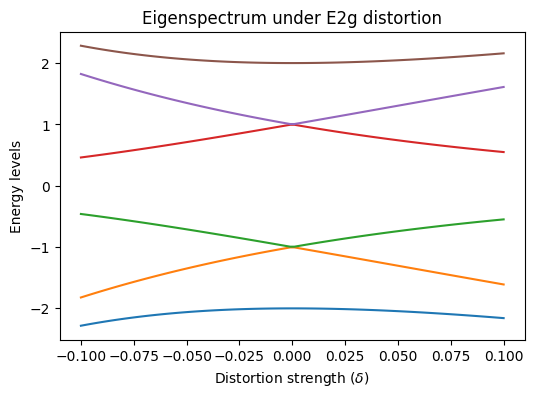

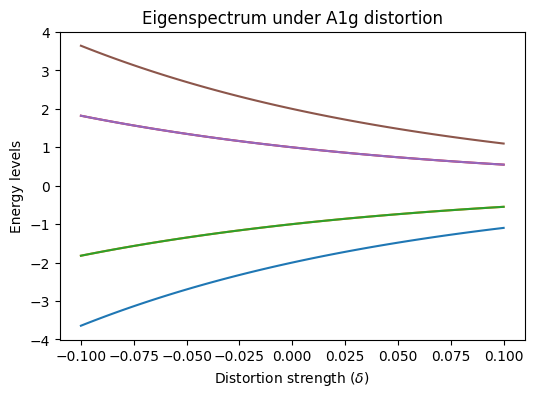

In [20]:
def plot_eigenspectra(mode, epsilon_range=np.linspace(-0.1, 0.1, 100), R=1.0):
    coords_0 = benzene_coords(R)
    d0 = np.linalg.norm(coords_0[0] - coords_0[1])
    eigs = []
    for eps in epsilon_range:
        distorted = apply_distortion(coords_0, mode=mode, epsilon=eps)
        H = compute_hamiltonian(distorted, t0=1.0, alpha=6.0, d0=d0)
        eigvals = np.linalg.eigvalsh(H)
        eigs.append(eigvals)

    eigs = np.array(eigs)
    plt.figure(figsize=(6, 4))
    plt.plot(epsilon_range, eigs)
    plt.xlabel("Distortion strength ($\delta$)")
    plt.ylabel("Energy levels")
    plt.title(f"Eigenspectrum under {mode} distortion")
    plt.show()

plot_eigenspectra(mode='E2g')
plot_eigenspectra(mode='A1g')

Visualize the structural distortions accompanying both these plots. How is the structure distorted in the first plot? What about the second?

In [28]:
def generate_dataset(mode='E2g', N=100, eps_range=(-0.1, 0.1), dtype = torch.float64):
    epsilons = np.linspace(*eps_range, N)
    coords_0 = benzene_coords()
    d0 = np.linalg.norm(coords_0[0] - coords_0[1])
    # X = epsilons[:, None]
    X = []
    Y = []
    Hs = []
    for eps in epsilons:
        coords = apply_distortion(coords_0, mode=mode, epsilon=eps)
        H = compute_hamiltonian(coords, alpha=6.0, d0=d0)
        X.append(coords)
        Hs.append(H)
        Y.append(np.linalg.eigvalsh(H))  # ground truth
    X = np.asarray(X)
    Y = np.array(Y)
    Hs = np.asarray(Hs)
    return torch.from_numpy(X).to(dtype=dtype), torch.from_numpy(Y).to(dtype=dtype), torch.from_numpy(Hs).to(dtype = dtype)



In [66]:
coords_e2g, gaps_e2g, Hs_e2g = generate_dataset()
e2g_distort = [ase.Atoms('C6', pos.numpy()) for pos in torch.nn.functional.pad(X, (0, 1))]
# view(e2g_distort) # visualize structures

<Popen: returncode: None args: ['/Users/jigyasa/miniconda3/bin/python', '-m'...>

In [65]:
coords_a1g, gaps_a1g, Hs_a1g = generate_dataset(mode = 'A1g')
a1g_distort = [ase.Atoms('C6', pos.numpy()) for pos in torch.nn.functional.pad(X, (0, 1))]
# view(a1g_distort) # visualize structures

<Popen: returncode: None args: ['/Users/jigyasa/miniconda3/bin/python', '-m'...>

In [75]:
# plt.plot(coords_a1g[:,:,0], coords_a1g[:,:,1])
# plt.plot(coords_e2g[:,:,0], coords_e2g[:,:,1], ls ='dotted')

In [87]:
# stack and shuffle 
torch.manual_seed(11314)
perm = torch.randperm(200)  


coords = torch.vstack((coords_a1g, coords_e2g))[perm]
gaps = torch.vstack((gaps_a1g, gaps_e2g))[perm]
Hs = torch.vstack((Hs_a1g, Hs_e2g))[perm]

In [96]:
class EigenvaluePredictor(nn.Module):
    def __init__(self, nin= 6, nhidden=64, nout = 6, activation='SiLU'):
        super().__init__()
        act = getattr(nn, activation)() if isinstance(activation, str) else activation
        self.model = nn.Sequential(
            nn.Linear(nin, nhidden),
            act,
            nn.Linear(nhidden, nhidden),
            act,
            nn.Linear(nhidden, nout)  # predict nout eigenvalues directly
        )

    def forward(self, x):  # x: [batch_size, nin]
        return self.model(x)  # [batch_size, nout]

def train_model(model, train_loader, test_loader, epochs=500, lr=1e-3):
    model = model.to(torch.float64)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            preds = model(xb)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            train_loss = sum(loss_fn(model(xb), yb).item() for xb, yb in train_loader) / len(train_loader)
            test_loss  = sum(loss_fn(model(xb), yb).item() for xb, yb in test_loader) / len(test_loader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)

    return train_losses, test_losses


In [100]:
X, Y = coords.reshape(coords.shape[0], -1), gaps
X_train, X_test = X[:150], X[150:]
Y_train, Y_test = Y[:150], Y[150:]

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=32, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test, Y_test), batch_size=32)

model_direct = EigenvaluePredictor(nin = 12, nhidden=64)
losses_direct = train_model(model_direct, train_loader, test_loader, epochs=500)

# Final evaluation
model_direct.eval()
with torch.no_grad():
    pred_direct = model_direct(X_test)


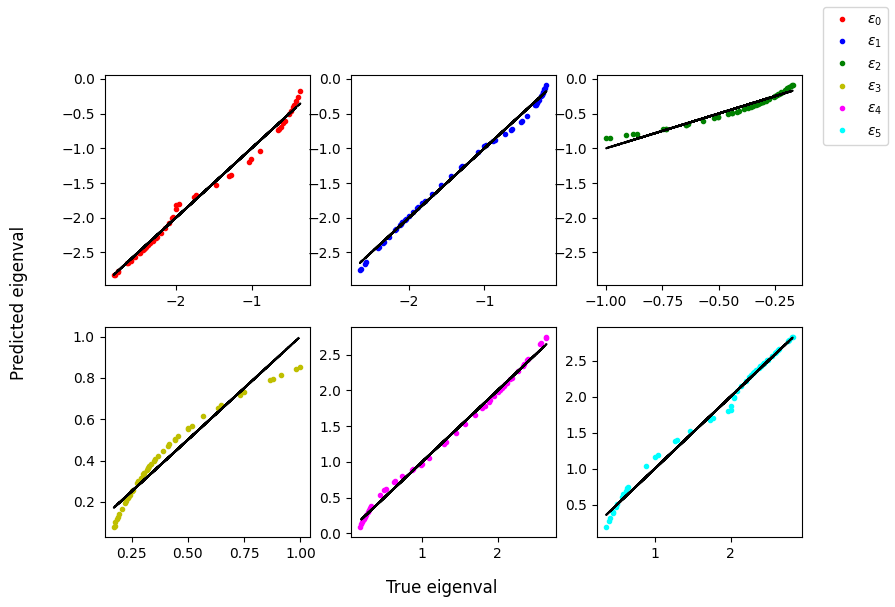

In [146]:
# Plot predictions on test set 
fig, axs = plt.subplots(2,3, figsize = (9,6))
axs[0,0].plot( Y_test[:,0], pred_direct[:,0 ], 'r.', label=r'$\varepsilon_0$')
axs[0,0].plot( Y_test[:,0], Y_test[:, 0], 'k--')

axs[0,1].plot( Y_test[:,1], pred_direct[:,1 ], 'b.', label=r'$\varepsilon_1$')
axs[0,1].plot( Y_test[:,1], Y_test[:, 1], 'k', ls ='--')
axs[0,1].sharey(axs[0,0])

axs[0,2].plot( Y_test[:,2], pred_direct[:,2 ], 'g.', label=r'$\varepsilon_2$')
axs[0,2].plot( Y_test[:,2], Y_test[:, 2], 'k--')
axs[0,2].sharey(axs[0,0])

axs[1,0].plot( Y_test[:,3], pred_direct[:,3 ], 'y.', label=r'$\varepsilon_3$')
axs[1,0].plot( Y_test[:,3], Y_test[:, 3], 'k--')
# axs[1,0].sharex(axs[0,0])

axs[1,1].plot( Y_test[:,4], pred_direct[:,4 ], 'magenta', marker='.', ls = 'None',label=r'$\varepsilon_4$')
axs[1,1].plot( Y_test[:,4], Y_test[:, 4], 'k--')

axs[1,2].plot( Y_test[:,5], pred_direct[:,5 ], 'cyan', marker = '.', ls = 'None', label=r'$\varepsilon_5$')
axs[1,2].plot( Y_test[:,5], Y_test[:, 5], 'k--')

fig.legend()

fig.supxlabel("True eigenval")
fig.supylabel("Predicted eigenval")
plt.show()

Verify if the models capture the degeneracy of the eigenvalues under A1g and E2g distortions. 

Let's now model the Hamiltonian. How many independent entries are there in a symmetric $6\times 6$ matrix? 

In [147]:
class BenzeneHamiltonianPredictor(nn.Module):
    def __init__(self, nin=6, nhidden=64, nout = 21, activation='SiLU', dtype=torch.float64):
        super().__init__()
        act = getattr(nn, activation)() if isinstance(activation, str) else activation
        self.model = nn.Sequential(
            nn.Linear(nin, nhidden),
            act,
            nn.Linear(nhidden, nhidden),
            act,
            nn.Linear(nhidden, nout) 
        )
        self.dtype = dtype

    def forward(self, x):  # x: [batch_size, nin]
        out = self.model(x)  # [batch_size, nout]
        batch_size = x.shape[0]
        H = torch.zeros(batch_size, 6, 6, dtype=self.dtype, device=x.device)

        idx = 0
        for i in range(6):
            for j in range(i, 6):
                H[:, i, j] = out[:, idx]
                H[:, j, i] = out[:, idx]
                idx += 1

        eigvals = torch.linalg.eigvalsh(H)  # [batch_size, 6], sorted
        return eigvals

In [148]:
X, Y = coords.reshape(coords.shape[0], -1), gaps
X_train, X_test = X[:150], X[150:]
Y_train, Y_test = Y[:150], Y[150:]

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test, Y_test), batch_size=32)

model_ham    = BenzeneHamiltonianPredictor(nin=12, nhidden=64)
losses_ham    = train_model(model_ham, train_loader, test_loader, epochs=500)

# Final evaluation
model_direct.eval()
model_ham.eval()
with torch.no_grad():
    pred_ham    = model_ham(X_test)

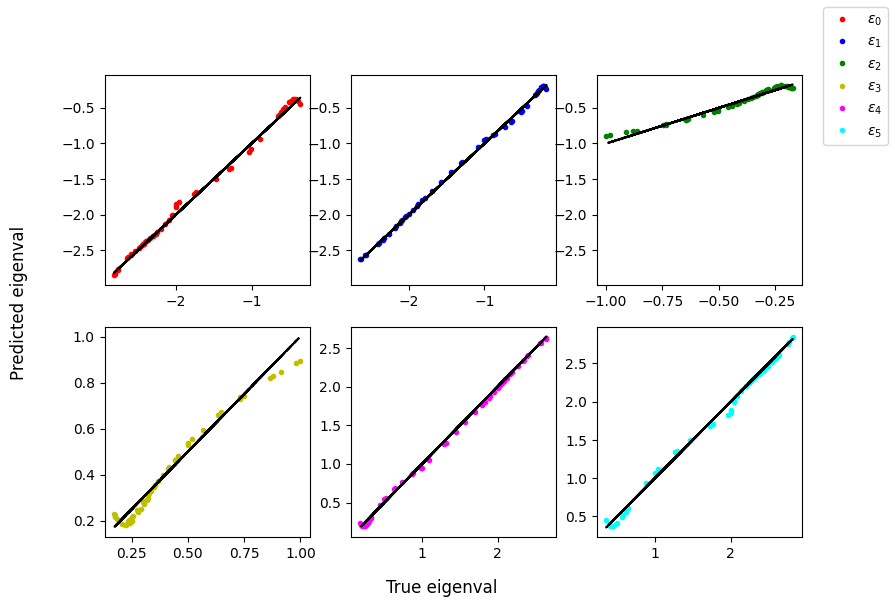

In [149]:
# Plot predictions on test set 
fig, axs = plt.subplots(2,3, figsize = (9,6))
axs[0,0].plot( Y_test[:,0], pred_ham[:,0 ], 'r.', label=r'$\varepsilon_0$')
axs[0,0].plot( Y_test[:,0], Y_test[:, 0], 'k--')

axs[0,1].plot( Y_test[:,1], pred_ham[:,1 ], 'b.', label=r'$\varepsilon_1$')
axs[0,1].plot( Y_test[:,1], Y_test[:, 1], 'k', ls ='--')
axs[0,1].sharey(axs[0,0])

axs[0,2].plot( Y_test[:,2], pred_ham[:,2 ], 'g.', label=r'$\varepsilon_2$')
axs[0,2].plot( Y_test[:,2], Y_test[:, 2], 'k--')
axs[0,2].sharey(axs[0,0])

axs[1,0].plot( Y_test[:,3], pred_ham[:,3 ], 'y.', label=r'$\varepsilon_3$')
axs[1,0].plot( Y_test[:,3], Y_test[:, 3], 'k--')
# axs[1,0].sharex(axs[0,0])

axs[1,1].plot( Y_test[:,4], pred_ham[:,4 ], 'magenta', marker='.', ls = 'None',label=r'$\varepsilon_4$')
axs[1,1].plot( Y_test[:,4], Y_test[:, 4], 'k--')

axs[1,2].plot( Y_test[:,5], pred_ham[:,5 ], 'cyan', marker = '.', ls = 'None', label=r'$\varepsilon_5$')
axs[1,2].plot( Y_test[:,5], Y_test[:, 5], 'k--')

fig.legend()

fig.supxlabel("True eigenval")
fig.supylabel("Predicted eigenval")
plt.show()

In the above, we are still optimizing on the eigenvalues computed from the intermediate Hamiltonian. Modify the `train_model` function to optimize just on the Hamiltonians and compare the eigenvalues

Another motivation behind modeling the intermediate Hamiltonian is so we can obtain other properties from the matrix, as it is the central object in QM. 
For example, we can obtain the density matrix, per-atom charges and bond-charges, dipole moments etc. from the Hamiltonian. These properties rely both on the eigenvectors and eigenvalues of the matrix. 

In [168]:
coord = coords_a1g[0]
H = Hs_a1g[0]

# Diagonalize the Hamiltonian
e_vals, e_vecs = torch.linalg.eigh(H)

# Assume 3 lowest levels occupied 
n_occupation = 3
rho = sum(torch.outer(e_vecs[:, i], e_vecs[:, i].conj()) for i in range(n_occupation)) 

# We can interpret the diagonal of density matrix as the per-atom charge
site_charges = torch.real(torch.diag(rho))

# and treat the off-diagonal elements as an indication of charge delocalization between bonds 
bond_orders = torch.real(rho)


In [171]:
print(f'Trace {torch.trace(rho)}') # equal to number of occupied orbitals
torch.allclose(rho@rho ,rho) # $rho^2 == rho$, i.e. rho acts a projector  on the Grassmannian Gr(k,n), which parameterizes k-dimensional subspaces of C^n


Trace 3.000000000000001


True

Check out [this work](https://pubs.acs.org/doi/10.1021/acs.jctc.5c00522), if you want to learn more about how we can leverage this framework for more interesting QM properties and embed more constraints within ML!

We explicitly built in Hermitian (symmetric nature of the matrix under transposition) symmetry into the model for the Hamiltonian. Suppose the task was to predict the density matrix. As you saw above, the density matrix obeys the property of being a positive semidefinite matrix such that $\rho^2 = \rho$. Furthermore, the trace of the matrix must equal the number of electrons in the molecule. How would you modify `BenzeneHamiltonianPredictor` to enforce these constraints in the model? 

Modify the models above to not only constrain the eigenvalues of the Hamiltonian, but also the density matrix computed from its eigenvectors 

# Bases with symmetries

In many effective single-particle theories, such as Hartree Fock (HF) or Density Functional Theory (DFT), the matrices $\mathbf{H}$ are written on a specific basis of spherical harmonics. This imparts the matrix with an interesting behavior under rotations. 


In [88]:
from IPython.display import HTML

HTML("""
<table>
<tr>
  <td><video width="320" controls><source src="figs/Hamiltonian-movie.mp4" type="video/mp4"></video></td>
  <td><video width="320" controls><source src="figs/h2o.mov" type="video/mp4"></video></td>
</tr>
</table>
""")

,


# How do we model simple symmetric objects?

We can extend the examples we have encountered for modeling the operator representation on a basis describe their invariance/equivariance under Euclidean transformations. 

We encode the symmetries of Euclidean transformations (rotations, inversions) and permutations of identical atoms (and orbital labels) in the model, either by constructing inputs that reflect these symmetries explicitly (as we did in the $H_2$ example above), or by incorporating symmetry in the model operations. 
In another lecture, you were (or will be) exposed to the symmetries of physical objects. 

Please see [Tutorial for Hamiltonian learning](https://atomistic-cookbook.org/examples/hamiltonian-qm7/hamiltonian-qm7.html), [Tutorial for Periodic Hamiltonian learning](https://atomistic-cookbook.org/examples/periodic-hamiltonian/periodic-hamiltonian.html) for more in-depth details